In [1]:
from epymorph.adrio import acs5
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame
import numpy as np

duration = 7 * 53 + 1
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28

In [2]:
true_beta.shape

(372,)

In [ ]:
from epymorph.parameter_fitting.dynamics import (
    GeometricBrownianMotion,
)
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters

In [4]:
from epymorph.parameter_fitting.distribution import Uniform

# params_space = {
#     "beta": EstimateParameters.TimeVarying(
#         distribution=Uniform(a=0.05, b=0.5),
#         dynamics=GeometricBrownianMotion(volatility=0.04),
#     )
# }

rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=StateScope.in_states(["AZ"], year=2015),
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    time_frame=TimeFrame.of("2022-10-01", duration),
    params={
        "beta": EstimateParameters.TimeVarying(
            distribution=Uniform(a=0.05, b=0.5),
            dynamics=GeometricBrownianMotion(volatility=0.04),
        ),
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

In [ ]:
from typing import List

from epymorph.parameter_fitting.filter.particle import Particle
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters

In [8]:
rng = np.random.default_rng(seed=1)
data = rume.evaluate_params(override_params=rume.params, rng=rng)

ConnectionError: HTTPSConnectionPool(host='api.census.gov', port=443): Max retries exceeded with url: /data/2015/acs/acs5?get=B01001_001E&for=state%3A04&key=d77e45d5dcdf333e0fbe720e99ac85fd69550d17 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001C810ED17D0>: Failed to resolve 'api.census.gov' ([Errno 11001] getaddrinfo failed)"))

In [ ]:
def initialize_particles(num_particles, rume, rng) -> List[Particle]:
    data = rume.evaluate_params(rng)
    initial_state = rume.initialize(data, rng)

    particles = []

    for _ in range(num_particles):
        parameters = {
            _: self.dynamic_params[_].distribution.rvs(
                size=rume.scope.nodes, random_state=rng
            )
            for _ in dynamic_params.keys()
        }

        # Create a Particle instance with the initial state and parameters
        particle = Particle(
            state=initial_state,
            parameters=parameters,
        )

        particles.append(particle)

    return particles


In [ ]:
data

In [6]:
import dataclasses
from epymorph import initializer
from epymorph.simulator.basic.basic_simulator import BasicSimulator


def propagate_particle(rume, particle, parameters, rng):
    # Create a copy of the RUME model with updated parameters and time frame
    rume_propagate = dataclasses.replace(
        rume,
        # time_frame=TimeFrame.of(date, duration),  # Set simulation duration
        strata=[
            dataclasses.replace(
                g, init=initializer.Explicit(initials=particle.state)
            )  # Initialize with state values
            for g in rume.strata  # For each stratum, set the initial state
        ],
    )

    # Initialize the simulation using the BasicSimulator from the Epymorph library
    sim = BasicSimulator(rume_propagate)

    # Run the simulation and collect the output based on observations
    # (dynamic params)
    output = sim.run(parameters, rng_factory=(lambda: rng))

    return output


In [7]:
from epymorph.parameter_fitting.utils.params_perturb import Perturb


def propagate_params(parameters, params_space, rng):
    # Update the parameters using their dynamics
    params_perturb = Perturb(1)
    propagated_parameters = []
    for parameter in parameters:
        new_parameters = {}
        for param, val in parameter.items():
            dynamics = params_space[param].dynamics
            if isinstance(dynamics, GeometricBrownianMotion):
                new_parameters[param] = params_perturb.gbm(
                    val, dynamics.volatility, rng
                )
            else:
                new_parameters[param] = val

        propagated_parameters.append(new_parameters)

    return propagated_parameters


In [ ]:
from epymorph.parameter_fitting.utils import utils


def run(particles, rume, params_space, rng, duration):
    # List to store the observation results
    observation_results = []

    # Dictionaries to store quantiles and mean values of each parameter over time
    param_quantiles = {key: [] for key in params_space.keys()}
    param_means = {key: [] for key in params_space.keys()}

    # List to store the parameter values of each particle for each day
    all_particle_params_per_day = []

    # Initialize particle parameters for the first time step
    particle_params = [particle.parameters for particle in particles]

    # Propagate parameters for each time step
    for t in range(duration):
        # Propagate parameters based on the current state
        propagated_params = propagate_params(particle_params, params_space, rng)

        # Dictionary to temporarily store parameter values for quantiles and means
        temp_key_values = {key: [] for key in param_quantiles.keys()}

        # Collect values for each parameter across all particles
        for param_set in propagated_params:
            for key in temp_key_values:
                if key in param_set:
                    temp_key_values[key].append(param_set[key])

        # Calculate and store the quantiles and means for each parameter
        for key, values in temp_key_values.items():
            if values:
                param_quantiles[key].append(utils.quantiles(np.array(values)))
                param_means[key].append(np.mean(values))
                all_particle_params_per_day.append(
                    {key: np.concatenate(values).tolist()}
                )

        # Update particle parameters for the next time step
        particle_params = propagated_params

    # After the final time step, create a dictionary of the final mean values of the parameters
    final_param_values = {key: np.array(param_means[key]) for key in param_means}

    # Propagate each particle using the final mean values
    for particle in particles:
        # Apply the model to each particle and collect the results
        result = propagate_particle(rume, particle, final_param_values, rng)
        observation_results.append(result)

    # Return all collected data: observations, final parameters, and quantiles/means of parameters
    return (
        observation_results,
        final_param_values,
        param_quantiles,
        param_means,
        np.array(all_particle_params_per_day),
    )


In [ ]:
(
    state_forecast,
    param_forecast,
    param_quantiles,
    param_values,
    all_particle_params_per_day,
) = run(particles, rume, params_space, rng, duration)

In [24]:
param_forecast

{'beta': array([0.28104335, 0.28280732, 0.2847075 , 0.28526529, 0.28590173,
        0.28682647, 0.28754072, 0.28914502, 0.28827249, 0.28750327,
        0.28882978, 0.29093184, 0.28983013, 0.28944823, 0.29033557,
        0.29213551, 0.28978905, 0.29501803, 0.29507988, 0.29610735,
        0.29644564, 0.2966724 , 0.29688202, 0.29752435, 0.29760311,
        0.29666696, 0.29497953, 0.29537941, 0.29511458, 0.29558548,
        0.29876629, 0.29608472, 0.29705205, 0.29823591, 0.29705718,
        0.29617673, 0.2965109 , 0.29670558, 0.29600107, 0.29527195,
        0.29571429, 0.29431314, 0.29258684, 0.29244372, 0.29277431,
        0.29517688, 0.29632076, 0.29675482, 0.2971774 , 0.29676343,
        0.29551641, 0.29361184, 0.29104686])}

In [65]:
all_particle_params_per_day

array([{'beta': [0.2849238374610619, 0.4916017016607661, 0.11789471008930302, 0.48931528060188884, 0.18784993084042334, 0.2460588144494458, 0.4214648022413951, 0.23313497354381835, 0.2880107458680155, 0.06422163485972036, 0.3789311392681503, 0.3069097033380293, 0.20327828630494074, 0.3862891477028046, 0.1864560634820763, 0.264909473625008, 0.10845833549330139, 0.23671433905938438, 0.1515331772820922, 0.16626283838761996, 0.38603115520952874, 0.17311393575916523, 0.26706260602038234, 0.47998612278794056, 0.47804574258280835, 0.37976331991227213, 0.28052061298063846, 0.17534244077008393, 0.12314029402159195, 0.4870496132543409, 0.27424203697445687, 0.0957665168884402, 0.3207248103000101, 0.38625249258629957, 0.30519921726791666, 0.46704054482331214, 0.06546071609840022, 0.28435772556399663, 0.24436922146545653, 0.07779408154795252, 0.32647467344038866, 0.42479437475672316, 0.3238677011873101, 0.16219283399639972, 0.41485172363589873, 0.28956493475313194, 0.2711886477894374, 0.37909465187

In [66]:
all_particle_params_per_day.shape

(53,)

C:\Users\sm4335\AppData\Local\Temp\ipykernel_5992\1149484311.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


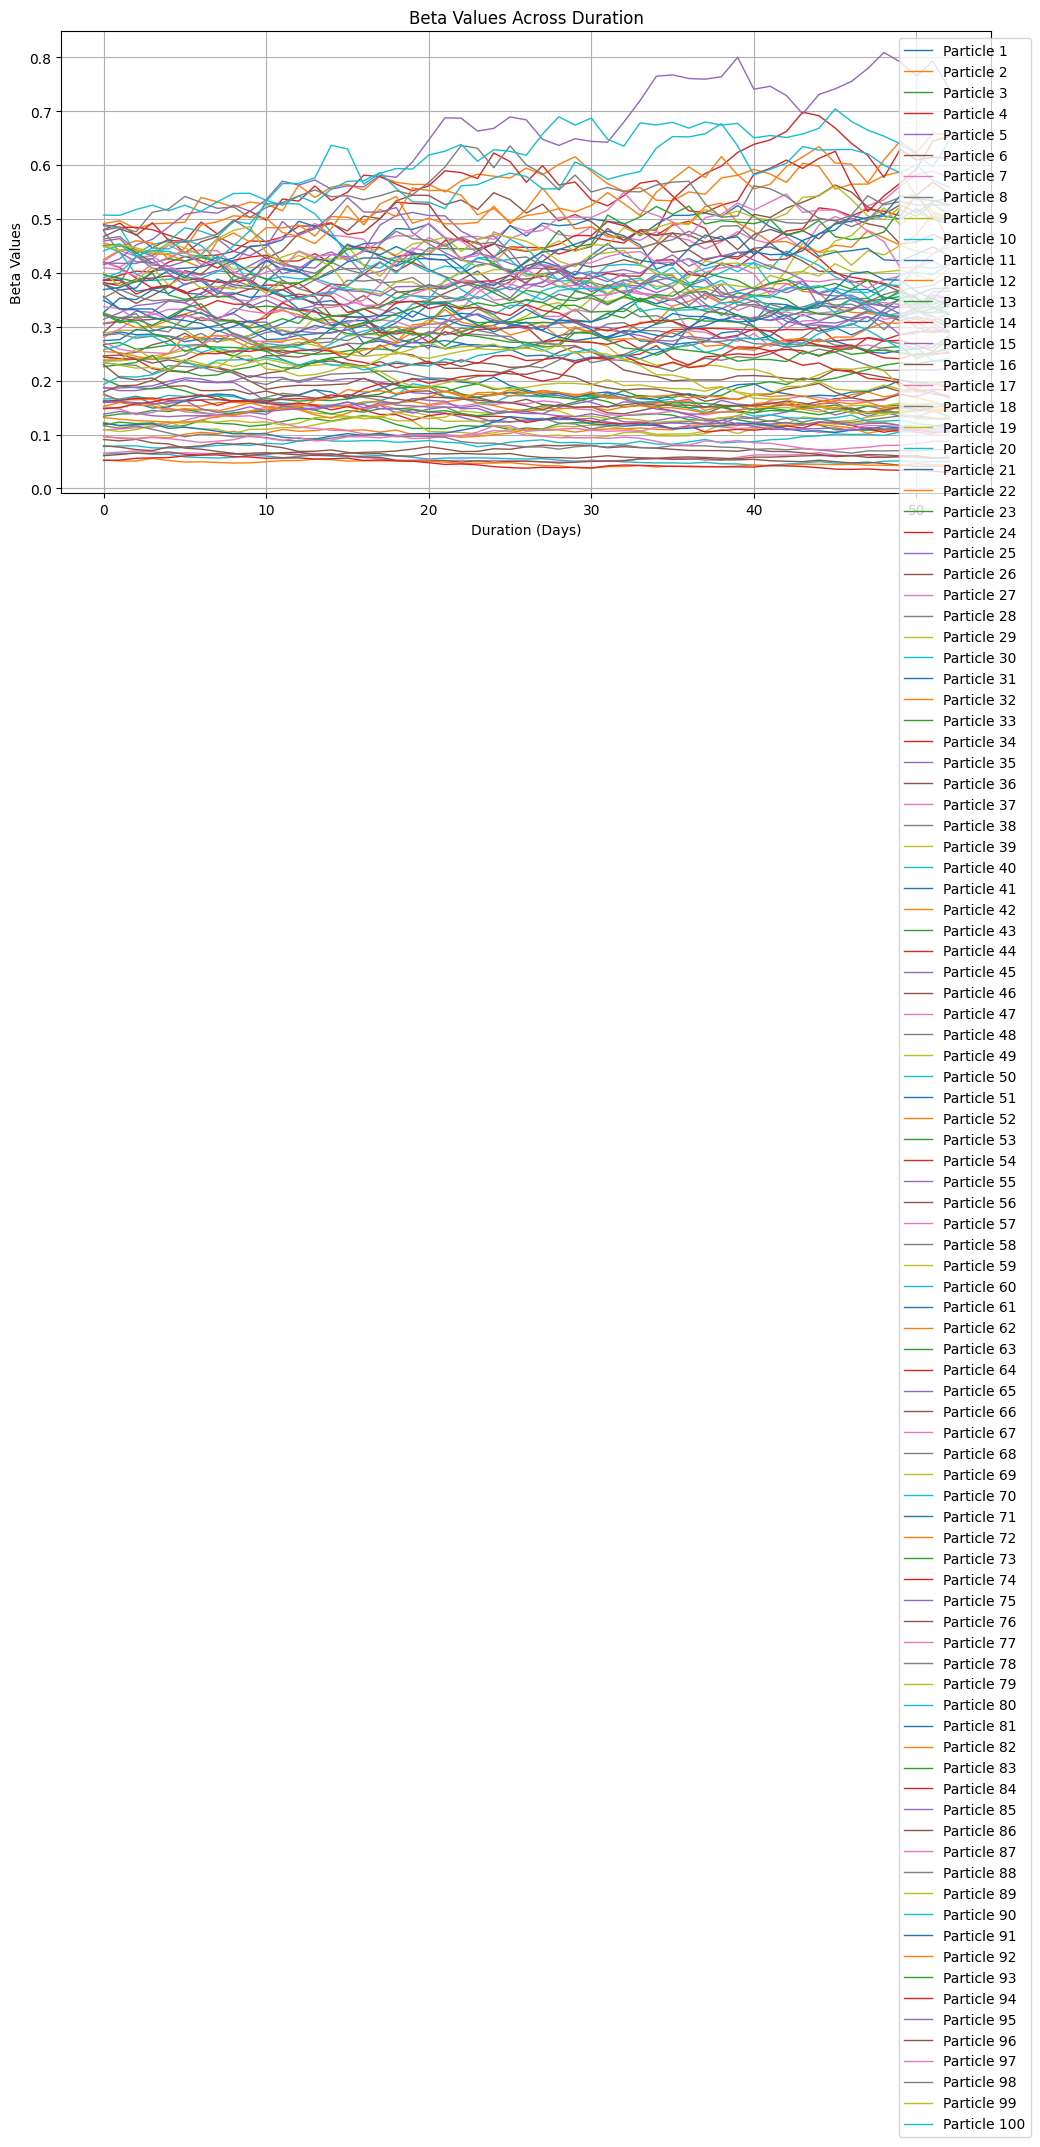

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_beta_values_over_duration(all_particle_params_per_day, key="beta"):
    """
    Plot the beta parameter values for each particle over the entire duration.

    Parameters:
    - all_particle_params_per_day (np.array): The data structure where each entry corresponds to a day's parameters (in dictionary format).
    - key (str): The key to plot (e.g., 'beta').
    """
    # Number of particles (assuming all days have the same number of particles)
    num_particles = len(
        all_particle_params_per_day[0][key]
    )  # Get number of particles (from the first day)
    duration = len(all_particle_params_per_day)  # Number of days (duration)

    # Create a figure for plotting
    plt.figure(figsize=(12, 6))

    # Plot the beta values for each particle
    for particle_idx in range(num_particles):
        particle_beta_values = []

        # Collect the beta values for this particle over all days
        for day_idx in range(duration):
            particle_beta_values.append(
                all_particle_params_per_day[day_idx][key][particle_idx]
            )

        # Plot the particle's beta values across the duration
        plt.plot(
            range(duration),
            particle_beta_values,
            label=f"Particle {particle_idx + 1}",
            linewidth=1,
        )

    # Add labels and title
    plt.title(f"{key.capitalize()} Values Across Duration")
    plt.xlabel("Duration (Days)")
    plt.ylabel(f"{key.capitalize()} Values")
    plt.legend(
        loc="upper right", bbox_to_anchor=(1.05, 1)
    )  # Adjust legend placement to avoid overlap
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()


# Example usage
# Assuming `all_particle_params_per_day` is a numpy array of shape (duration, num_particles), each entry being a dictionary like {'beta': [val1, val2, ...]}
# Plot the 'beta' values across the duration
plot_beta_values_over_duration(all_particle_params_per_day, key="beta")


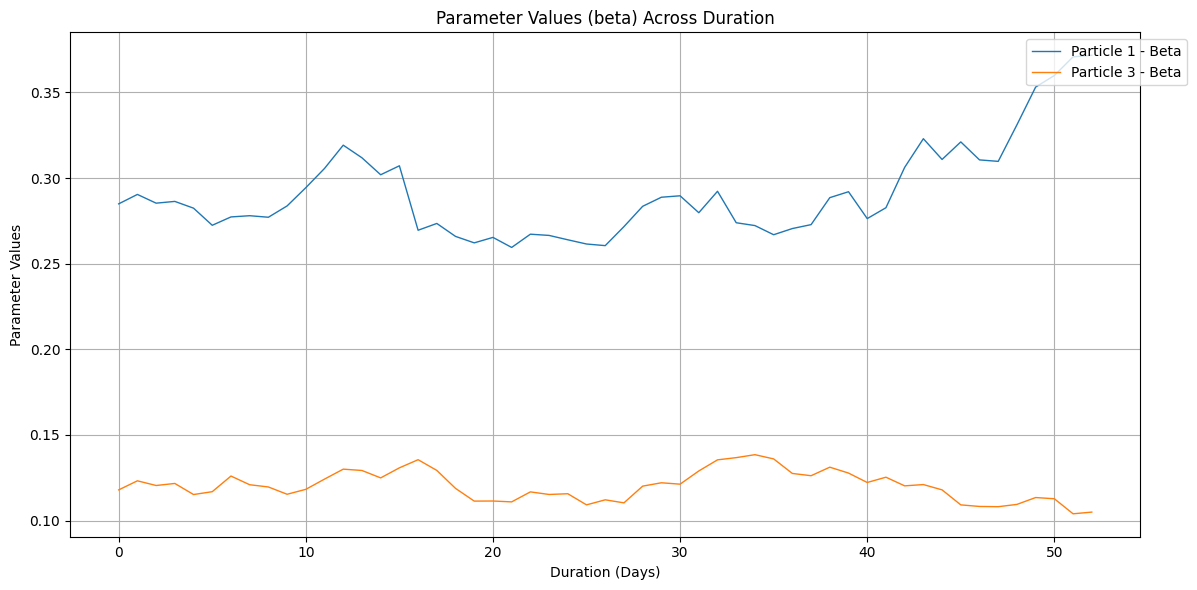

In [ ]:
import numpy as np


def plot_param_values_over_duration(
    all_particle_params_per_day, keys=["beta"], particles=None
):
    """
    Plot the parameter values for selected particles across the entire duration.

    Parameters:
    - all_particle_params_per_day (np.array): The data structure where each entry corresponds to a day's parameters (in dictionary format).
    - keys (list of str): List of keys (parameters) to plot (e.g., ['beta', 'alpha']).
    - particles (list of int, optional): List of particle indices to plot. If None, all particles will be plotted.
    """
    # Number of particles (assuming all days have the same number of particles)
    num_particles = len(
        all_particle_params_per_day[0][keys[0]]
    )  # Get number of particles (from the first day)
    duration = len(all_particle_params_per_day)  # Number of days (duration)

    # If particles is None, plot all particles
    if particles is None:
        particles = range(num_particles)

    # Create a figure for plotting
    plt.figure(figsize=(12, 6))

    # Loop through each key and plot its values
    for key in keys:
        for particle_idx in particles:
            particle_values = []

            # Collect the values for this particle and key (over all days)
            for day_idx in range(duration):
                particle_values.append(
                    all_particle_params_per_day[day_idx][key][particle_idx]
                )

            # Plot the particle's values for this key across the duration
            plt.plot(
                range(duration),
                particle_values,
                label=f"Particle {particle_idx + 1} - {key.capitalize()}",
                linewidth=1,
            )

    # Add labels and title
    plt.title(f"Parameter Values ({', '.join(keys)}) Across Duration")
    plt.xlabel("Duration (Days)")
    plt.ylabel("Parameter Values")
    plt.legend(
        loc="upper right", bbox_to_anchor=(1.05, 1)
    )  # Adjust legend placement to avoid overlap
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()


# Example usage
# Assuming `all_particle_params_per_day` is a numpy array of shape (duration, num_particles), each entry being a dictionary like {'beta': [val1, val2, ...]}
# User can specify which particles and which keys to plot:
plot_param_values_over_duration(
    all_particle_params_per_day, keys=["beta"], particles=[0, 2]
)


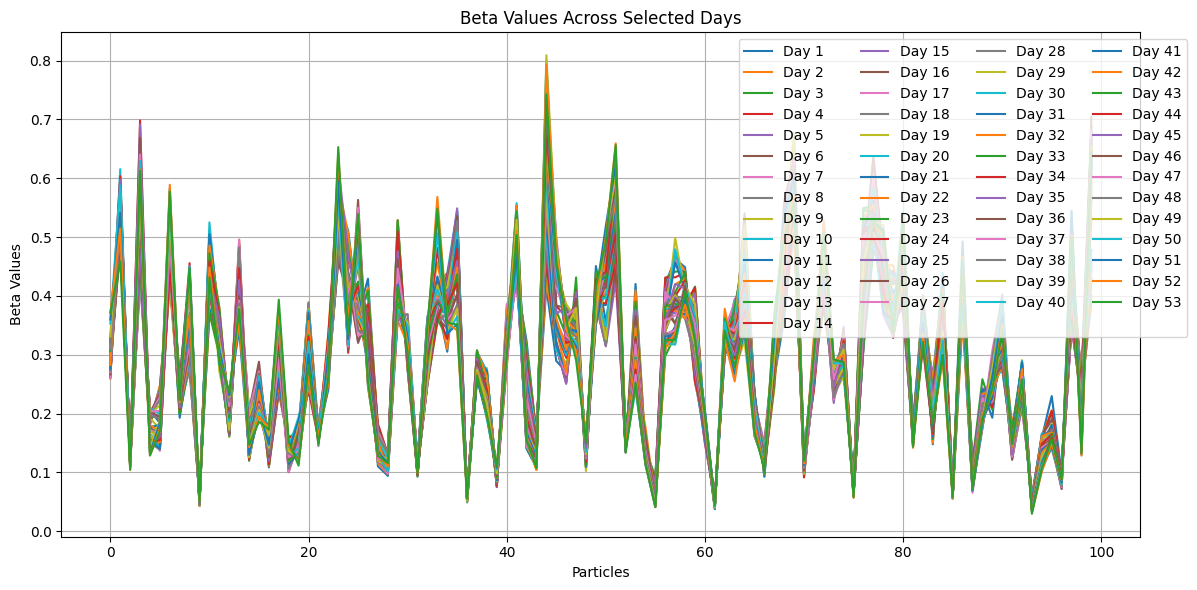

In [ ]:
def plot_param_for_days(all_particle_params_per_day, key, days_to_plot=None):
    """
    Plot the parameter values for a given key across selected days.

    Parameters:
    - all_particle_params_per_day (list of dicts): Data for each day, where each day is a dictionary with keys like 'beta'.
    - key (str): The key in the dictionary for which to plot the values (e.g., 'beta').
    - days_to_plot (list of int, optional): List of days to plot (1-based index, e.g., [1, 5, 10]). If None, plot all days.
    """
    # If no days are specified, plot all available days
    if days_to_plot is None:
        days_to_plot = range(1, len(all_particle_params_per_day) + 1)

    # Extract the parameter values for the given key from the specified days
    param_values_per_day = []
    for day_idx in days_to_plot:
        # Convert day_idx to 0-based index (e.g., day 1 -> index 0)
        if day_idx - 1 < len(all_particle_params_per_day):
            param_values_per_day.append(
                all_particle_params_per_day[day_idx - 1].get(key, [])
            )
        else:
            print(f"Warning: Day {day_idx} not found in data.")
            param_values_per_day.append([])  # Empty list for missing days

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot the parameter values for each day
    for day_idx, param_values in zip(days_to_plot, param_values_per_day):
        if param_values:  # Only plot if there are values
            plt.plot(param_values, label=f"Day {day_idx}")
        else:
            print(f"No {key} values found for Day {day_idx}.")

    # Customize the plot
    plt.title(f"{key.capitalize()} Values Across Selected Days")
    plt.xlabel("Particles")
    plt.ylabel(f"{key.capitalize()} Values")
    plt.legend(
        loc="upper right", bbox_to_anchor=(1.05, 1), ncol=4
    )  # Adjust legend placement
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()


# Example Usage
# all_particle_params_per_day = [
#     {'beta': [0.2849238374610619, 0.4916017016607661, 0.11789471008930302, 0.48931528060188884, 0.18784993084042334]},
#     {'beta': [0.29042961063622796, 0.49673997307963064, 0.12319185081000605, 0.4843945685785808, 0.18148728248250948]},
#     # More data for other days...
# ]

# Plot for the 'beta' parameter for days 1, 2
plot_param_for_days(all_particle_params_per_day, "beta")


In [ ]:
import plotly.graph_objects as go


def plot_param_for_days_interactive(
    all_particle_params_per_day, key, days_to_plot=None
):
    """
    Plot the parameter values for a given key across selected days in an interactive plot.

    Parameters:
    - all_particle_params_per_day (list of dicts): Data for each day, where each day is a dictionary with keys like 'beta'.
    - key (str): The key in the dictionary for which to plot the values (e.g., 'beta').
    - days_to_plot (list of int, optional): List of days to plot (1-based index, e.g., [1, 5, 10]). If None, plot all days.
    """
    # If no days are specified, plot all available days
    if days_to_plot is None:
        days_to_plot = range(1, len(all_particle_params_per_day) + 1)

    # Create a figure
    fig = go.Figure()

    # Extract the parameter values for the given key from the specified days
    for day_idx in days_to_plot:
        # Convert day_idx to 0-based index (e.g., day 1 -> index 0)
        if day_idx - 1 < len(all_particle_params_per_day):
            param_values = all_particle_params_per_day[day_idx - 1].get(key, [])
            if param_values:
                fig.add_trace(
                    go.Scatter(
                        x=list(range(len(param_values))),
                        y=param_values,
                        mode="lines",
                        name=f"Day {day_idx}",
                        line=dict(width=2),
                    )
                )
        else:
            print(f"Warning: Day {day_idx} not found in data.")

    # Update layout with titles, labels, and other settings
    fig.update_layout(
        title=f"{key.capitalize()} Values Across Selected Days",
        xaxis_title="Particles",
        yaxis_title=f"{key.capitalize()} Values",
        showlegend=True,
    )

    # Show the interactive plot
    fig.show()


# Example Usage
all_particle_params_per_day = [
    {
        "beta": [
            0.2849238374610619,
            0.4916017016607661,
            0.11789471008930302,
            0.48931528060188884,
            0.18784993084042334,
        ]
    },
    {
        "beta": [
            0.29042961063622796,
            0.49673997307963064,
            0.12319185081000605,
            0.4843945685785808,
            0.18148728248250948,
        ]
    },
    # More data for other days...
]

# Plot for the 'beta' parameter for days 1 and 2
plot_param_for_days_interactive(
    all_particle_params_per_day, "beta", days_to_plot=[1, 2]
)


ModuleNotFoundError: No module named 'plotly'

In [57]:
len(all_particle_params_per_day)

53

In [56]:
all_particle_params_per_day

[{'beta': [0.3006162672028947,
   0.5094011804118573,
   0.11541234669907627,
   0.47528398427704605,
   0.19421697246818376,
   0.2632873104401525,
   0.3952985651584484,
   0.2273660001339495,
   0.3187991467562973,
   0.0596782049967692,
   0.4078181127520136,
   0.3082919925213335,
   0.19350931905335453,
   0.41233053444073947,
   0.18534532381083774,
   0.24697639825982817,
   0.11998943182028159,
   0.22551208207422585,
   0.14271228965996752,
   0.179587832751625,
   0.3845676997853316,
   0.17816074293995754,
   0.25935437382865534,
   0.5003582603116173,
   0.5048337289553252,
   0.348524995056562,
   0.27955524340810045,
   0.1870615190389539,
   0.12425217612034216,
   0.4695971011156274,
   0.28905808141674766,
   0.10142600496348006,
   0.3605266913423811,
   0.4217880493988031,
   0.30167005999571667,
   0.4646001527928542,
   0.06644896647595787,
   0.299235650473905,
   0.2745867110044813,
   0.08175721917723332,
   0.34900320240146815,
   0.41910744956362955,
   0.312

In [ ]:
list(np.concatenate(all_particle_params_per_day[0]["beta"]))

[0.27358184812455655,
 0.5103747691059216,
 0.1116426236427511,
 0.4779698666475191,
 0.17878500245042034,
 0.24895725497644408,
 0.4408304767440703,
 0.2305849467092077,
 0.2943389409484825,
 0.062400141838696355,
 0.41513407408474756,
 0.30126229779400887,
 0.20442726096998068,
 0.40258525818652763,
 0.19053613980487633,
 0.23861873848667067,
 0.1141515993108521,
 0.2447863581381489,
 0.14416265595579256,
 0.16273450618851143,
 0.38340219387049174,
 0.17362854183246212,
 0.27770262188483535,
 0.477570242382042,
 0.4659597920392206,
 0.3659088065059211,
 0.31173053687494867,
 0.1695376583158547,
 0.13003228979555456,
 0.5125293853060404,
 0.26335849818310364,
 0.0992598479308907,
 0.3479197225247781,
 0.39290841782696045,
 0.32650443378599875,
 0.4643269993774989,
 0.06576244484056311,
 0.25958453338177745,
 0.24794572728915756,
 0.07792827037691721,
 0.33525095829867163,
 0.44163894674066834,
 0.2959029060537076,
 0.1762102568343158,
 0.4377869008496989,
 0.2742621347169213,
 0.28778

In [32]:
len(all_particle_params_per_day[1])

1

In [15]:
state_forecast

[Output(rume=SingleStrataRUME(strata=[GPM(name='all', ipm=<epymorph.data.ipm.sirh.SIRH object at 0x000001ACE3CFD3D0>, mm=<epymorph.data.mm.no.No object at 0x000001ACF7B4C5D0>, init=<epymorph.initializer.Explicit object at 0x000001ACFFC39690>, params=None)], ipm=<epymorph.data.ipm.sirh.SIRH object at 0x000001ACE3CFD3D0>, mms=OrderedDict([('all', <epymorph.data.mm.no.No object at 0x000001ACF7B4C5D0>)]), scope=StateScope(year=2015, granularity='state', includes_granularity='state', includes=('04',), _node_ids=array(['04'], dtype='<U2')), time_frame=TimeFrame(start_date=datetime.date(2022, 10, 1), duration_days=53, end_date=datetime.date(2022, 11, 22)), params={NamePattern(strata='*', module='*', id='beta'): array([0.31      , 0.30999556, 0.30998222, 0.30996   , 0.30992891,
        0.30988895, 0.30984012, 0.30978246, 0.30971597, 0.30964068,
        0.3095566 , 0.30946377, 0.3093622 , 0.30925194, 0.309133  ,
        0.30900543, 0.30886927, 0.30872456, 0.30857133, 0.30840963,
        0.30823

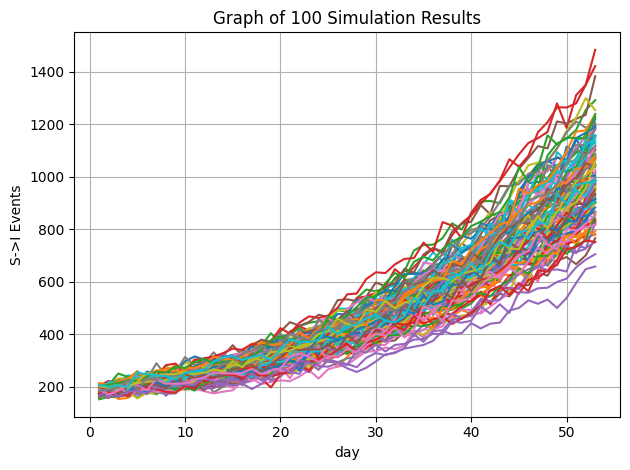

In [ ]:
fig, ax = plt.subplots()

# This uses the more advanced line_plt() functionality
for j in state_forecast:
    j.plot.line_plt(
        ax=ax,
        geo=j.rume.scope.select.all(),
        time=j.rume.time_frame.select.all(),
        quantity=j.rume.ipm.select.events("S->I"),
    )

ax.set_xlabel("day")
ax.set_ylabel("S->I Events")
ax.set_title("Graph of 100 Simulation Results")
ax.grid(True)

fig.tight_layout()
plt.show()

In [ ]:
from epymorph.time import EveryNDays
from epymorph.parameter_fitting.utils.observations import ModelLink

quantity_selection = rume.ipm.select.events("I->H")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()

model_link = ModelLink(
    quantity=quantity_selection,
    time=time_selection,
    geo=geo_selection,
)

In [ ]:
from epymorph.tools.data import munge


data_df = munge(
    state_forecast[0],
    geo=model_link.geo,
    time=dataclasses.replace(model_link.time, time_frame=rume_propagate.time_frame),
    quantity=model_link.quantity,
)

In [ ]:
# # Plot the compartment values in Florida throughout the simulation.
# out.plot.line(
#     geo=rume.scope.select.by_state("Florida"),
#     time=rume.time_frame.select.all(),
#     quantity=rume.ipm.select.compartments(),
#     title="Compartment values in Florida",
#     label_format="{q}",
# )

# Plot new occurrences for the S->I event for all places.
# Because the number of events that occur in any time step
# is sensitive to the length of that time step, and especially
# because the tau steps for this simulation are of varying length,
# we will group and sum by day to smooth out the inter-day variation.
out.plot.line(
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all().group("day").agg(),
    quantity=rume.ipm.select.events("S->I"),
    title="New infections in all states",
    label_format="{n}",
)

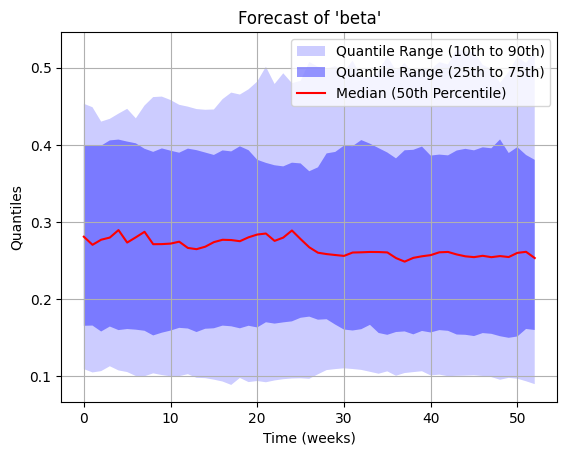

In [11]:
import matplotlib.pyplot as plt

key = "beta"
node_index = 0
truth = None

key_quantiles = np.array(param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)


plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [12]:
param_forecast

{'beta': array([0.28046361, 0.27887219, 0.27892905, 0.28036053, 0.28071153,
        0.28014267, 0.27827749, 0.27936772, 0.27866   , 0.27716506,
        0.27690535, 0.27736645, 0.27715639, 0.27609791, 0.27656297,
        0.27586765, 0.27824471, 0.28035227, 0.28141455, 0.28308772,
        0.28277938, 0.28361634, 0.28182135, 0.28119879, 0.28446746,
        0.28508696, 0.28472564, 0.2841363 , 0.28597771, 0.28603927,
        0.2873507 , 0.28726711, 0.28945907, 0.28911958, 0.28701363,
        0.28741677, 0.28560188, 0.2859522 , 0.28473902, 0.28660407,
        0.28680424, 0.28722848, 0.28698299, 0.28943991, 0.29014296,
        0.28856496, 0.28743884, 0.28542273, 0.28282601, 0.28296859,
        0.28325422, 0.28456214, 0.2860963 ])}

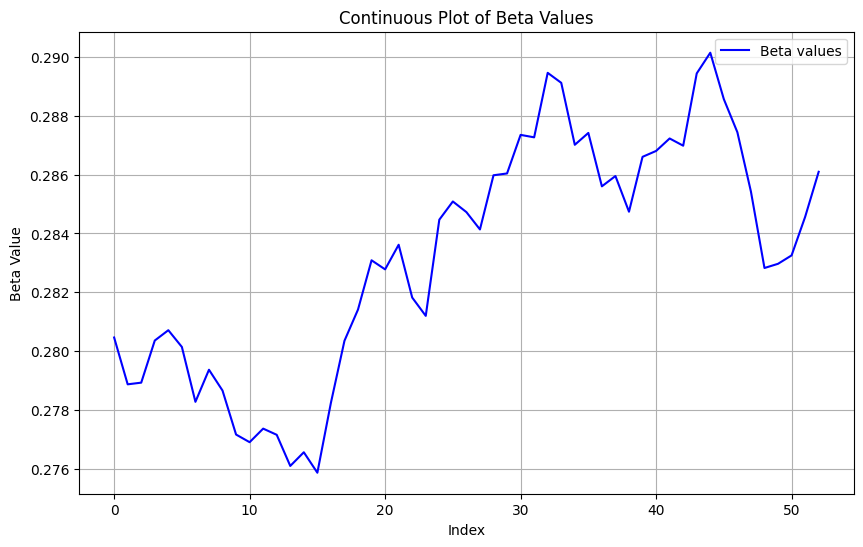

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the beta values
beta_values = param_forecast["beta"]

# Create a continuous plot (single line)
plt.figure(figsize=(10, 6))
plt.plot(beta_values, color="b", label="Beta values")
plt.title("Continuous Plot of Beta Values")
plt.xlabel("Index")
plt.ylabel("Beta Value")
plt.grid(True)
plt.legend()
plt.show()
